# KD Seminar
## Analyse der Modelle RNN/CNN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

---

In [84]:
finance_data = pd.read_csv("finance_data/data/aggregated_returns.csv",index_col=0)

modell = "mlp/predictions/predictions_frst_model_non_training_data_with_data_augmentation_early_cut.csv"
# Load portfolio data
#
#portfolio_data = pd.read_csv(modell,sep='\t')
portfolio_data = pd.read_csv(modell)



# Both Ascending by Time
finance_data = finance_data.sort_values('Timestamp')
portfolio_data = portfolio_data.sort_values('Timestamp')

# Set Index
finance_data = finance_data.set_index('Timestamp')
portfolio_data = portfolio_data.set_index('Timestamp')

stocks = finance_data.columns

In [85]:
# Set Both Datasets on same time range
start = max(portfolio_data.index.min(),finance_data.index.min())
end =  min(portfolio_data.index.max(),finance_data.index.max())
finance_data = finance_data.loc[start:end]
portfolio_data = portfolio_data.loc[start:end]


# Check has to be 0
portfolio_data.shape[0] - finance_data.shape[0]

0

---

In [86]:
# Shift portfolio binary variable to day where investment get paid out
# Set 1 to day when return is realized or 0 when return is not realized
# shift > 0 --> Shift nach unten
# shift < 0 --> shift nach oben
for stock in stocks:
    portfolio_data[stock] = portfolio_data[stock].shift(1)

# Cant invest before the first day 
portfolio_data=portfolio_data.fillna(0)

---

In [87]:
# Calculate Mean return for equal weighted strategy
equal_weighted_mean = finance_data.mean(1,True)

# Shorting?
#finance_data = finance_data.apply(lambda row: row*-1)
#finance_data['Equal_Weighted_Mean'] = finance_data['Equal_Weighted_Mean']*-1

In [88]:
# Reset Index
# Damit .loc[] funktioniert
finance_data = finance_data.reset_index()
portfolio_data = portfolio_data.reset_index()

In [91]:
# Clear all return entries, where we do not want to invest
for stock in stocks:
    finance_data.loc[np.where(portfolio_data[stock]==0)[0],[stock]] = np.nan

In [24]:
# Calculate mean returns for model
finance_data['Model_Mean'] = finance_data.mean(1,True)
finance_data['Equal_Weighted_Mean'] = equal_weighted_mean.values



# Plot Equal Weighted Strategy vs. Model with Buy when 1 

Zeitraum: 2017-03-16  -  2018-06-18
Modell: mlp/predictions/predictions_frst_model_non_training_data_with_data_augmentation_early_cut.csv


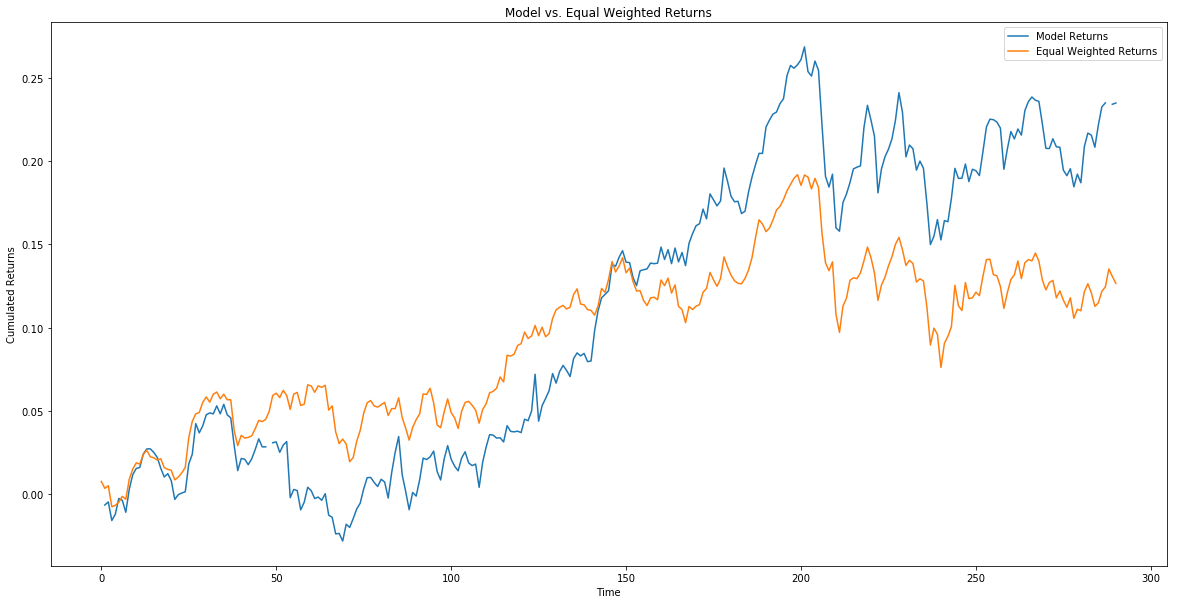

In [25]:
# Plot Model vs Equal Weight Strategy

print("Zeitraum:", start," - ",end)
print("Modell:",modell)

plt.figure(0,figsize=[20,10])
plt.plot(finance_data['Model_Mean'].cumsum(),label="Model Returns")
plt.plot(finance_data['Equal_Weighted_Mean'].cumsum(),label="Equal Weighted Returns")

plt.title("Model vs. Equal Weighted Returns")
plt.xlabel("Time")
plt.ylabel("Cumulated Returns")
plt.legend()
plt.show()


---

---

# -------------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------------

# Long-Short Strategy

In [2]:
finance_data = pd.read_csv("finance_data/data/aggregated_returns.csv",index_col=0)

tp_modell = "mlp/predictions/predictions_frst_model_non_training_data_with_different_data_augmentation_2_late.csv"
tn_modell = "mlp/predictions/predictions_frst_model_non_training_data_with_different_data_augmentation_2_nicht_ganz_so_early.csv"


# Load portfolio data
#
#portfolio_data = pd.read_csv(modell,sep='\t')
tp_portfolio_data = pd.read_csv(tp_modell)
tn_portfolio_data = pd.read_csv(tn_modell)




# Both Ascending by Time
finance_data = finance_data.sort_values('Timestamp')
tp_portfolio_data = tp_portfolio_data.sort_values('Timestamp')
tn_portfolio_data = tn_portfolio_data.sort_values('Timestamp')



# Set Index
finance_data = finance_data.set_index('Timestamp')
tp_portfolio_data = tp_portfolio_data.set_index('Timestamp')
tn_portfolio_data = tn_portfolio_data.set_index('Timestamp')



stocks = finance_data.columns

In [3]:
# Set Both Datasets on same time range
start = max(tp_portfolio_data.index.min(),finance_data.index.min(),tn_portfolio_data.index.min())
end =  min(tp_portfolio_data.index.max(),finance_data.index.max(),tn_portfolio_data.index.max())
finance_data = finance_data.loc[start:end]
tp_portfolio_data = tp_portfolio_data.loc[start:end]
tn_portfolio_data = tn_portfolio_data.loc[start:end]



# Check has to be 0
tp_portfolio_data.shape[0] - finance_data.shape[0]

0

---

In [4]:
# Shift portfolio binary variable to day where investment get paid out
# Set 1 to day when return is realized or 0 when return is not realized
# shift > 0 --> Shift nach unten
# shift < 0 --> shift nach oben
for stock in stocks:
    tp_portfolio_data[stock] = tp_portfolio_data[stock].shift(1)
    tn_portfolio_data[stock] = tn_portfolio_data[stock].shift(1)


# Cant invest before the first day 
tp_portfolio_data=tp_portfolio_data.fillna(0)
tn_portfolio_data=tn_portfolio_data.fillna(0)

---

In [5]:
# Calculate Mean return for equal weighted strategy
equal_weighted_mean = finance_data.mean(1,True)

In [6]:
# Copy DF for filter matrix 
# ptf_mask gets filled with 0 from tn_portfolio data
# ptf_mask gets filled with 1 from tp_portfolio_data

ptf_mask = tp_portfolio_data.copy()
ptf_mask.loc[:] = np.nan

In [7]:
# Reset Index
# Damit .loc[] funktioniert
finance_data = finance_data.reset_index()

tp_portfolio_data = tp_portfolio_data.reset_index()
tn_portfolio_data = tn_portfolio_data.reset_index()

ptf_mask = ptf_mask.reset_index()

In [34]:
# Fill ptf_mask with 0/1


for stock in stocks:
    buy_indices = np.where(tp_portfolio_data[stock]==1)[0]
    sell_indices = np.where(tn_portfolio_data[stock]==0)[0]
    nan_indices = np.intersect1d(buy_indices,sell_indices)
    
    ptf_mask.loc[buy_indices,[stock]] = 1
    ptf_mask.loc[sell_indices,[stock]] = 0
    ptf_mask.loc[nan_indices,[stock]] = np.nan

---

### Calculate Long and Shorting Means 

In [35]:
tp_finance_data = finance_data.copy()
tn_finance_data = finance_data.copy()

In [36]:
# TPs
# Clear all return entries, where we do not want to invest
for stock in stocks:
    tp_finance_data.loc[np.where(ptf_mask[stock]!=1)[0],[stock]] = np.nan

In [37]:
# Long 
# Set all Nans to 0, where we do not invest
tp_finance_data['Model_Mean_Long'] = tp_finance_data.mean(1,True)
tp_finance_data.loc[np.isnan(tp_finance_data['Model_Mean_Long']),'Model_Mean_Long']=0

In [38]:
# TNs
# Clear all return entries, where we do not want to invest
for stock in stocks:
    tn_finance_data.loc[np.where(ptf_mask[stock]!=0)[0],[stock]] = np.nan

In [39]:
# Shorting -> *-1
# Set all Nans to 0, where we do not invest
tn_finance_data['Model_Mean_Short'] = tn_finance_data.mean(1,True)*(-1)
tn_finance_data.loc[np.isnan(tn_finance_data['Model_Mean_Short']),'Model_Mean_Short']=0

---

In [40]:
# Set mean returns for model and equal weight strategy 

finance_data['Model_Mean_Short'] = tn_finance_data['Model_Mean_Short'] 
finance_data['Model_Mean_Long'] = tp_finance_data['Model_Mean_Long'] 
finance_data['Model_Mean'] = finance_data['Model_Mean_Long'] + finance_data['Model_Mean_Short']


finance_data['Equal_Weighted_Mean'] = equal_weighted_mean.values

# Plot Equal Weighted Strategy vs. Model with Buy when 1 

Zeitraum: 2016-08-01  -  2018-06-18
TN Modell: mlp/predictions/predictions_frst_model_non_training_data_with_different_data_augmentation_2_nicht_ganz_so_early.csv
TP Modell: mlp/predictions/predictions_frst_model_non_training_data_with_different_data_augmentation_2_late.csv


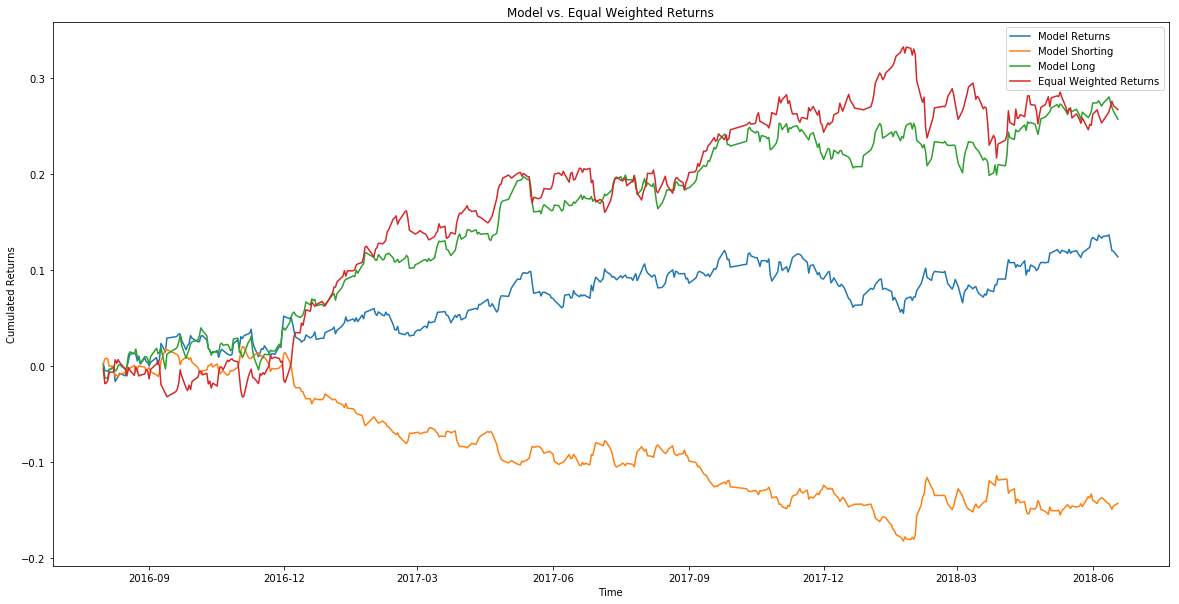

In [41]:
# Plot Model vs Equal Weight Strategy

print("Zeitraum:", start," - ",end)
print("TN Modell:",tn_modell)
print("TP Modell:",tp_modell)



plt.figure(0,figsize=[20,10])
plt.plot(pd.to_datetime(finance_data['Timestamp']),finance_data['Model_Mean'].cumsum(),label="Model Returns")
plt.plot(pd.to_datetime(finance_data['Timestamp']),finance_data['Model_Mean_Short'].cumsum(),label="Model Shorting")
plt.plot(pd.to_datetime(finance_data['Timestamp']),finance_data['Model_Mean_Long'].cumsum(),label="Model Long")



plt.plot(pd.to_datetime(finance_data['Timestamp']),finance_data['Equal_Weighted_Mean'].cumsum(),label="Equal Weighted Returns")

plt.title("Model vs. Equal Weighted Returns")
plt.xlabel("Time")
plt.ylabel("Cumulated Returns")
plt.legend()
plt.show()


# -------------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------------

# Sonstiges

In [69]:
finance_data[0:10]

,Timestamp,Samsung,Telefonica,Allianz,Total,Bayer,Tesla,Airbus,Apple,BASF,BMW,Google,Model_Mean,Equal_Weighted_Mean
0,2016-05-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-05-10,NaN,NaN,0.020318,NaN,0.001499,NaN,NaN,NaN,NaN,NaN,NaN,0.010908,NaN
2,2016-05-11,NaN,NaN,0.015240,NaN,0.049716,NaN,NaN,NaN,NaN,NaN,NaN,0.032478,NaN
3,2016-05-12,NaN,NaN,-0.008374,NaN,-0.010351,NaN,NaN,NaN,NaN,NaN,NaN,-0.009363,NaN
4,2016-05-13,NaN,NaN,0.006183,NaN,0.004065,NaN,NaN,NaN,NaN,NaN,NaN,0.005124,NaN
5,2016-05-17,NaN,NaN,-0.004368,NaN,-0.006974,NaN,NaN,NaN,NaN,NaN,NaN,-0.005671,NaN
6,2016-05-18,NaN,NaN,0.010223,NaN,0.085599,NaN,NaN,NaN,NaN,NaN,NaN,0.047911,NaN
7,2016-05-19,NaN,NaN,-0.010949,NaN,-0.011571,NaN,NaN,NaN,NaN,NaN,NaN,-0.011260,NaN
8,2016-05-20,NaN,NaN,0.000363,NaN,0.058881,NaN,NaN,NaN,NaN,NaN,NaN,0.029622,NaN
9,2016-05-23,NaN,NaN,-0.030045,NaN,-0.031827,NaN,NaN,NaN,NaN,NaN,NaN,-0.030936,NaN


In [25]:
finance_data[0:10].apply(lambda row: row*-1)

,Timestamp,Samsung,Telefonica,Allianz,Total,Bayer,Tesla,Airbus,Apple,BASF,BMW,Google,Equal_Weighted_Mean,Model_Mean
0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010444,0.010444
1,,NaN,NaN,-0.020318,NaN,-0.001499,NaN,NaN,NaN,NaN,NaN,NaN,-0.004629,-0.008815
2,,NaN,NaN,-0.015240,NaN,-0.049716,NaN,NaN,NaN,NaN,NaN,NaN,-0.014593,-0.026516
3,,NaN,NaN,0.008374,NaN,0.010351,NaN,NaN,NaN,NaN,NaN,NaN,-0.005292,0.004478
4,,NaN,NaN,-0.006183,NaN,-0.004065,NaN,NaN,NaN,NaN,NaN,NaN,0.000120,-0.003376
5,,NaN,NaN,0.004368,NaN,0.006974,NaN,NaN,NaN,NaN,NaN,NaN,-0.001220,0.003374
6,,NaN,NaN,-0.010223,NaN,-0.085599,NaN,NaN,NaN,NaN,NaN,NaN,-0.009774,-0.035199
7,,NaN,NaN,0.010949,NaN,0.011571,NaN,NaN,NaN,NaN,NaN,NaN,0.012051,0.011524
8,,NaN,NaN,-0.000363,NaN,-0.058881,NaN,NaN,NaN,NaN,NaN,NaN,-0.006177,-0.021807
9,,NaN,NaN,0.030045,NaN,0.031827,NaN,NaN,NaN,NaN,NaN,NaN,0.017764,0.026545


In [131]:
finance_data

,Samsung,Telefonica,Allianz,Total,Bayer,Tesla,Airbus,Apple,BASF,BMW,Google
Timestamp,,,,,,,,,,,
2010-06-29,0.022990,-0.031939,-0.005759,0.002937,-0.005449,0.002515,0.002350,0.018279,0.003982,-0.004127,0.026947
2010-06-30,0.010390,-0.023302,0.021987,-0.013874,0.009283,0.081723,0.051293,0.012200,0.027190,0.047668,0.019717
2010-07-01,-0.001305,-0.010501,-0.004610,0.011670,0.026683,0.134312,0.018751,0.006217,0.001368,0.008280,0.034667
2010-07-02,0.000000,0.009063,0.009995,-0.005852,0.001240,0.175470,-0.012851,-0.006820,0.011355,-0.005921,0.010506
2010-07-06,0.007772,-0.018515,-0.007211,-0.035820,-0.006629,0.019430,-0.023836,-0.039568,0.001796,-0.019048,0.002878
2010-07-07,-0.007772,-0.002818,-0.012705,-0.009107,-0.012907,-0.099903,-0.007130,0.002225,-0.011395,0.021359,-0.026867
2010-07-08,-0.026736,-0.005146,-0.008858,-0.007642,-0.008549,0.003442,-0.007667,-0.005911,-0.016198,-0.006149,-0.015313
2010-07-09,-0.007509,0.013152,-0.007598,-0.002074,-0.000215,0.020320,-0.007901,0.009035,-0.006211,0.006278,-0.019291
2010-07-12,0.007509,-0.006598,-0.012225,-0.017796,-0.011250,-0.061969,-0.030427,0.021557,-0.010159,-0.079637,-0.026611


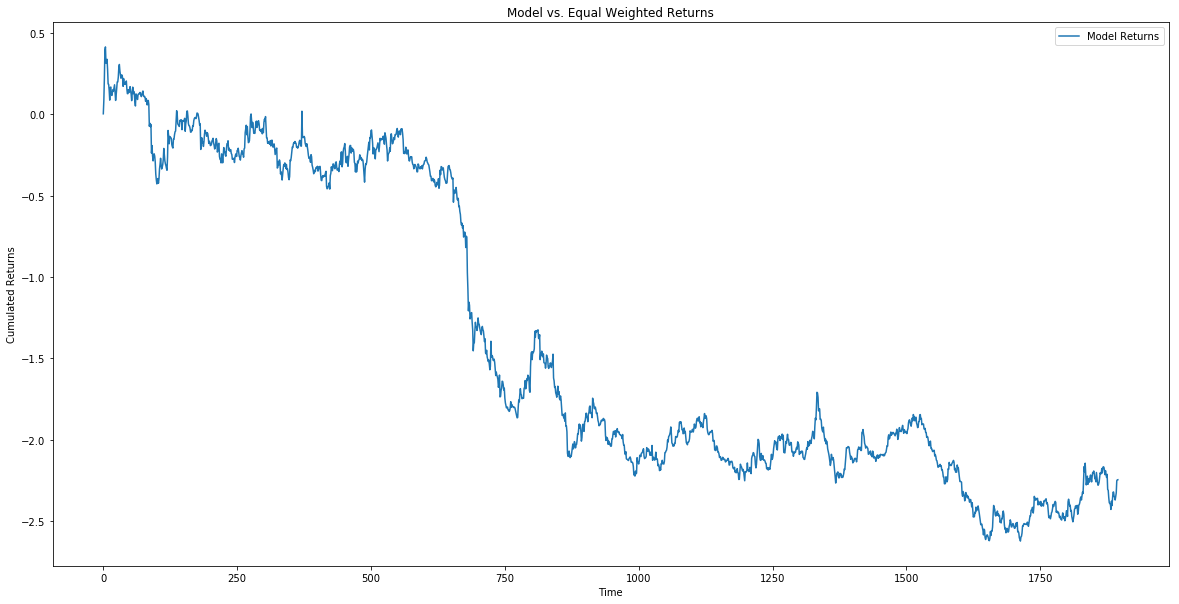

In [134]:
# Plot Model vs Equal Weight Strategy

plt.figure(0,figsize=[20,10])
plt.plot(finance_data['Tesla'].values.cumsum(),label="Model Returns")

plt.title("Model vs. Equal Weighted Returns")
plt.xlabel("Time")
plt.ylabel("Cumulated Returns")
plt.legend()
plt.show()

